## Classification of each ball 

### Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import preprocessing 
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix
import re,nltk, textblob, string
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVC
import warnings
warnings.filterwarnings("ignore")

C:\Users\dell\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Reading the Datasets

In [2]:
#Creating a dataframe
data=pd.read_csv("DSAT Data.csv")

In [3]:
#Checking the head and shape of the data
data.head()

,ID,Match_ID,Over,Commentary,Over_Run_Total,Target
0,0,8.040000e+11,49.6,and india reach 300. there has been a 300 in ...,4,Run_Bw_Wickets
1,1,8.040000e+11,49.5,"slower ball, ashwin bunts this to leg for -99...",4,Run_Bw_Wickets
2,2,8.040000e+11,49.4,"full toss on off, he just slogs, gets a thick...",4,Run_Bw_Wickets
3,3,8.040000e+11,49.3,that's the closest you'll get to a hat-trick ...,4,Dot
4,4,8.040000e+11,49.2,sohail is doing the sajda after bowling rahan...,4,Wicket


In [4]:
data.shape

(101634, 6)

### Missing Value Analysis

In [5]:
data.isnull().sum()

ID                0
Match_ID          0
Over              0
Commentary        0
Over_Run_Total    0
Target            0
dtype: int64

### Checking For outliers through Boxplots 

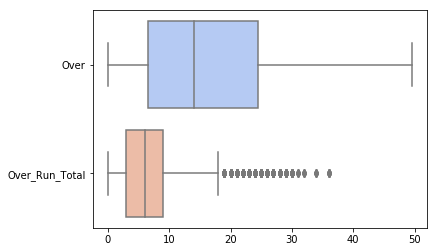

In [6]:
data_box=data.drop(['ID','Match_ID','Target','Commentary'],axis=1)
sns.boxplot(data=data_box,palette='coolwarm',orient='h')

### Since Total Runs in an over is not exceeding 36 and Over number is not exceeding 50, we can assume that there are no outliers.

### Creating a new column Over_number which tells us only the over number rather than the ball number.

In [12]:
data['Over_number']=data['Over'].apply(lambda x:str(x)[0:2].rstrip('.'))

In [14]:
data.head(2)

,ID,Match_ID,Over,Commentary,Over_Run_Total,Target,Over_number
0,0,8.040000e+11,49.6,and india reach 300. there has been a 300 in ...,4,Run_Bw_Wickets,49
1,1,8.040000e+11,49.5,"slower ball, ashwin bunts this to leg for -99...",4,Run_Bw_Wickets,49


### Creating a new dataframe with text column Commentary and ID for further anaylsis

In [20]:
data_text = data[['Commentary','ID']]

In [21]:
%%time
# Lower casing the words and tokenizing them and then stemming them using Prter Stemmer.
data_text ['Commentary'].dropna(inplace=True)
data_text['Commentary'] = [entry.lower() for entry in data_text['Commentary']]

# Replacing the string -999 from the commentary whichs looks like a typo
data_text['Commentary'] =data_text['Commentary'].replace(to_replace ="-999", value = "", regex = True)
data_text['Commentary'] =data_text['Commentary'].replace(to_replace =",", value = "", regex = True)

data_text['Commentary']= [word_tokenize(entry) for entry in data_text['Commentary']]

Wall time: 1min 34s


In [22]:
pst = PorterStemmer()
data_text['Commentary']=data_text['Commentary'].apply(lambda x: ' '.join([pst.stem(i) for i in x]))   

In [23]:
data_text[['Commentary']].head(2)

,Commentary
0,and india reach 300. there ha been a 300 in ev...
1,slower ball ashwin bunt thi to leg for after w...


### Creating a new vectorized dataframe

In [24]:
%%time
#Creating a TF-IDF vector of text column Commentary
vect= TfidfVectorizer(max_features=1000,max_df=0.95, min_df=2,ngram_range = (1,2),stop_words='english')
data_text_vect = pd.DataFrame(vect.fit_transform(data_text['Commentary']).toarray()) 

Wall time: 20.3 s


### Concatenating the original dataframe data and vectorized data frame.

In [25]:
vect= TfidfVectorizer(max_features=1000,max_df=0.95, min_df=2,ngram_range = (1,2),stop_words='english')
data_text_vect = pd.DataFrame(vect.fit_transform(data_text['Commentary']).toarray()) 
train=pd.concat([data,data_text_vect],axis=1)
train.head(2)

,ID,Match_ID,Over,Commentary,Over_Run_Total,Target,Over_number,0,1,2,...,990,991,992,993,994,995,996,997,998,999
0,0,8.040000e+11,49.6,and india reach 300. there has been a 300 in ...,4,Run_Bw_Wickets,49,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,8.040000e+11,49.5,"slower ball, ashwin bunts this to leg for -99...",4,Run_Bw_Wickets,49,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Manipulating the Target variable by encoding it and storing it in a different dataframe.

In [26]:
label_encoder = LabelEncoder()
data['Target']= label_encoder.fit_transform(data['Target']) 

#creating a new target dataframe
target=data[['Target']]
target.head(2)

,Target
0,2
1,2


### Dropping columns from training dataframe

In [27]:
train.drop(['Target','Commentary','ID','Match_ID','Over'],inplace=True,axis=1)

In [28]:
train.head(2)

,Over_Run_Total,Over_number,0,1,2,3,4,5,6,7,...,990,991,992,993,994,995,996,997,998,999
0,4,49,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4,49,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Splitting the data into Test and Train data

In [29]:
%%time
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(train,target,test_size=0.3,random_state=216)

Wall time: 3.05 s


### Running different models using training and testing data

In [31]:
%%time
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(train,target,test_size=0.3,random_state=216)
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RNDF', RandomForestClassifier()))
models.append(('NB', naive_bayes.MultinomialNB()))

# evaluate each model in turn
results = []
names = []
for name, model in models:
    model.fit(Train_X,Train_Y)
    predictions_NB = model.predict(Train_X)
    print("{} model Accuracy Score -> {} " .format(name,accuracy_score(predictions_NB, Train_Y)*100))
    predictions_NB = model.predict(Test_X)
    # Use accuracy_score function to get the accuracy
    print("{} model Accuracy Score -> {} " .format(name,accuracy_score(predictions_NB, Test_Y)*100))

LR model Accuracy Score -> 79.17574462701882 
LR model Accuracy Score -> 78.15420943885081 
KNN model Accuracy Score -> 72.7267615928482 
KNN model Accuracy Score -> 59.24043160276803 
CART model Accuracy Score -> 99.96485950831425 
CART model Accuracy Score -> 68.05286805942737 
RNDF model Accuracy Score -> 98.87690988572312 
RNDF model Accuracy Score -> 74.08087632416122 
NB model Accuracy Score -> 65.68320143935455 
NB model Accuracy Score -> 65.12085533436095 
Wall time: 18min 50s


In [142]:
%%time
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(train,target,test_size=0.3,random_state=216)
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RNDF', RandomForestClassifier()))
models.append(('NB', naive_bayes.MultinomialNB()))

# evaluate each model in turn
results = []
names = []
for name, model in models:
    model.fit(Train_X,Train_Y)
    predictions_NB = model.predict(Test_X)
    # Use accuracy_score function to get the accuracy
    print("{} model Accuracy Score -> {} " .format(name,accuracy_score(predictions_NB, Test_Y)*100))

LR model Accuracy Score -> 79.56774130071167 
KNN model Accuracy Score -> 59.68318520219081 
CART model Accuracy Score -> 69.27290020005903 
RNDF model Accuracy Score -> 75.36322193434128 
NB model Accuracy Score -> 66.15394706634746 
Wall time: 8min 34s


### Applying Adaboost Classifier

In [143]:
%%time
#Fit a AdaBoost model, " compared to "Logistic Regression, accuracy is down by 5%
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(train,target,test_size=0.3,random_state=216)
clf = AdaBoostClassifier(n_estimators=100)
clf.fit(Train_X,Train_Y)
y_pred = clf.predict(Test_X)
print("Accuracy Score : ",accuracy_score(Test_Y, y_pred)*100)

Accuracy Score :  0.7233281952051425
Wall time: 3min 40s


### Applying Gradient Boosting Classifier

In [144]:
%%time
#Fit a Gradient Boosting model, " compared to "Logistic Regression, accuracy is down by 3%
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(train,target,test_size=0.3,random_state=216)
clf = GradientBoostingClassifier(n_estimators=100)
clf.fit(Train_X,Train_Y)
y_pred = clf.predict(Test_X)
print("Accuracy Score : ",accuracy_score(Test_Y, y_pred)*100)

Accuracy Score :  76.08146666229379
Wall time: 30min 32s


### Logistic Regression model classifies the data better than any other model with an accuracy of 79.5%

In [149]:
%%time
# Fitting the Logistic Regression Model again to print of classification report. 
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(train,target,test_size=0.3,random_state=216)
clf = LogisticRegression(solver='liblinear', multi_class='ovr')
clf.fit(Train_X,Train_Y)
y_pred = clf.predict(Test_X)
print("Accuracy Score : ",accuracy_score(Test_Y, y_pred)*100)
print("Confusion Matrix :")
print(confusion_matrix(Test_Y, y_pred))
print("Classification Report :")
print(classification_report(Test_Y, y_pred))

Accuracy Score :  79.56774130071167
Confusion Matrix :
[[ 2356   252   977    20]
 [  132 11133  1401    59]
 [  460  2263 10201    80]
 [   91   295   200   571]]
Classification Report :
             precision    recall  f1-score   support

          0       0.78      0.65      0.71      3605
          1       0.80      0.87      0.83     12725
          2       0.80      0.78      0.79     13004
          3       0.78      0.49      0.61      1157

avg / total       0.80      0.80      0.79     30491

Wall time: 52.1 s


### f1- score of the model is also pretty good which is a good indicator that the modeling is good at classifying even if our data was uneven.